## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R
install.packages('tidycensus')

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille) 

Selection:  66



The downloaded binary packages are in
	/var/folders/lm/ltt61ln55pdb08_0zxtv_ym40000gn/T//RtmpdeDfnL/downloaded_packages


trying URL 'https://cran.wustl.edu/bin/macosx/big-sur-arm64/contrib/4.4/tidycensus_1.7.1.tgz'
Content type 'application/x-gzip' length 3554938 bytes (3.4 MB)
downloaded 3.4 MB

In addition: Warning message:
In doTryCatch(return(expr), name, parentenv, handler) :
  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <34C5A480-1AC4-30DF-83C9-30A913FC042E> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: tried: '/opt/X11/lib/libSM.6.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/X11/lib/libSM.6.dylib' (no such file), '/opt/X11/lib/libSM.6.dylib' (no such file), '/usr/local/lib/libSM.6.dylib' (no such file), '/usr/lib/libSM.6.dylib' (no such file, not in dyld cache)


In [6]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key

Get a Census API key [here](https://api.census.gov/data/key_signup.html).

Then make a new file called `.env` in this folder and put it in there. 

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. We load it below in Python

In [5]:
pip install python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

False

In [9]:
%%R 
# passes the CENSUS_API_KEY environment variable we loaded
# in Python above to R (specifically to the tidycensus package)
census_api_key(Sys.getenv("CENSUS_API_KEY"),install = TRUE)

[1] ""


Your API key has been stored in your .Renviron and can be accessed by Sys.getenv("CENSUS_API_KEY"). 
To use now, restart R or run `readRenviron("~/.Renviron")`


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [7]:
%%R

require('tigris')

In [8]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/


# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        total_units = "B25001_001",
                        med_inc="B19013_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T,
                        )

nyc_census_data <- nyc_census_data %>%
                    erase_water()


Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'
Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.
In addition: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [9]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

nyc_census_data

Simple feature collection with 2324 features and 8 fields
Geometry type: GEOMETRY
Dimension:     XY
Bounding box:  xmin: -74.25571 ymin: 40.49611 xmax: -73.70036 ymax: 40.91528
Geodetic CRS:  NAD83
# A tibble: 2,324 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>            <GEOMETRY [°]>               <dbl>            <dbl>
 1 3608101… Cens… POLYGON ((-73.91499 40.7…                2863            71815
 2 3604705… Cens… POLYGON ((-73.96085 40.5…                3655            67315
 3 3606100… Cens… GEOMETRYCOLLECTION (LINE…                2450           237500
 4 3604707… Cens… POLYGON ((-73.93312 40.6…                2676           117857
 5 3604710… Cens… POLYGON ((-73.90652 40.6…                3004            76207
 6 3604705… Cens… POLYGON ((-73.96155 40.7…                1834           107410
 7 3600502… Cens… POLYGON ((-73.92048 40.8…                4030            37200
 8 3608104… Cens… POLYGON ((-73.77985 40.7…        

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [10]:
%%R 

# Extract borough name from NAME by splitting strings like "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
        units_per_person = total_units_estimate / population_estimate # create new variable
    ) 

nyc_census_data

Simple feature collection with 2324 features and 10 fields
Geometry type: GEOMETRY
Dimension:     XY
Bounding box:  xmin: -74.25571 ymin: 40.49611 xmax: -73.70036 ymax: 40.91528
Geodetic CRS:  NAD83
# A tibble: 2,324 × 11
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>            <GEOMETRY [°]>               <dbl>            <dbl>
 1 3608101… Cens… POLYGON ((-73.91499 40.7…                2863            71815
 2 3604705… Cens… POLYGON ((-73.96085 40.5…                3655            67315
 3 3606100… Cens… GEOMETRYCOLLECTION (LINE…                2450           237500
 4 3604707… Cens… POLYGON ((-73.93312 40.6…                2676           117857
 5 3604710… Cens… POLYGON ((-73.90652 40.6…                3004            76207
 6 3604705… Cens… POLYGON ((-73.96155 40.7…                1834           107410
 7 3600502… Cens… POLYGON ((-73.92048 40.8…                4030            37200
 8 3608104… Cens… POLYGON ((-73.77985 40.7…      

In [ ]:
%%R



### Step 5 | Example Plots

Let's practice with histograms

In [17]:
%%R

rlang::last_trace()

<error/rlang_error>
Error in `combine_vars()`:
! At least one layer must contain all faceting variables: `borough`
✖ Plot is missing `borough`
✖ Layer 1 is missing `borough`
---
Backtrace:
     ▆
  1. ├─methods (local) `<stndrdGn>`(`<gg>`)
  2. └─methods (local) `<stndrdGn>`(`<gg>`)
  3.   └─methods::showDefault(object)
  4.     ├─base::print(object, useS4 = FALSE)
  5.     └─ggplot2:::print.ggplot(object, useS4 = FALSE)
  6.       ├─ggplot2::ggplot_build(x)
  7.       └─ggplot2:::ggplot_build.ggplot(x)
  8.         └─layout$setup(data, plot$data, plot$plot_env)
  9.           └─ggplot2 (local) setup(..., self = self)
 10.             └─self$facet$compute_layout(data, self$facet_params)
 11.               └─ggplot2 (local) compute_layout(..., self = self)
 12.                 └─ggplot2::combine_vars(data, params$plot_env, vars, drop = params$drop)
Run rlang::last_trace(drop = FALSE) to see 2 hidden frames.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 85 rows containing non-finite outside the scale range (`stat_bin()`). 



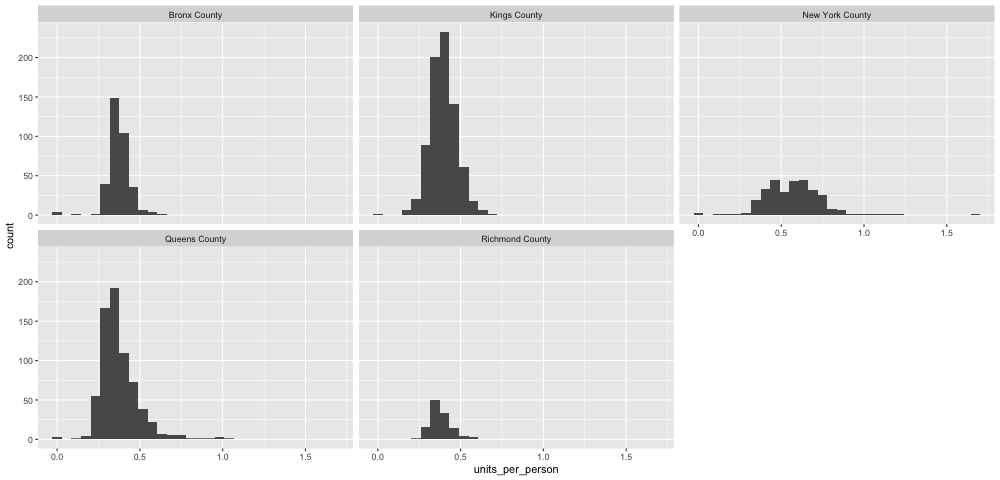

In [11]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_histogram() + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 88 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 85 rows containing missing values or values outside the scale range
(`geom_point()`). 



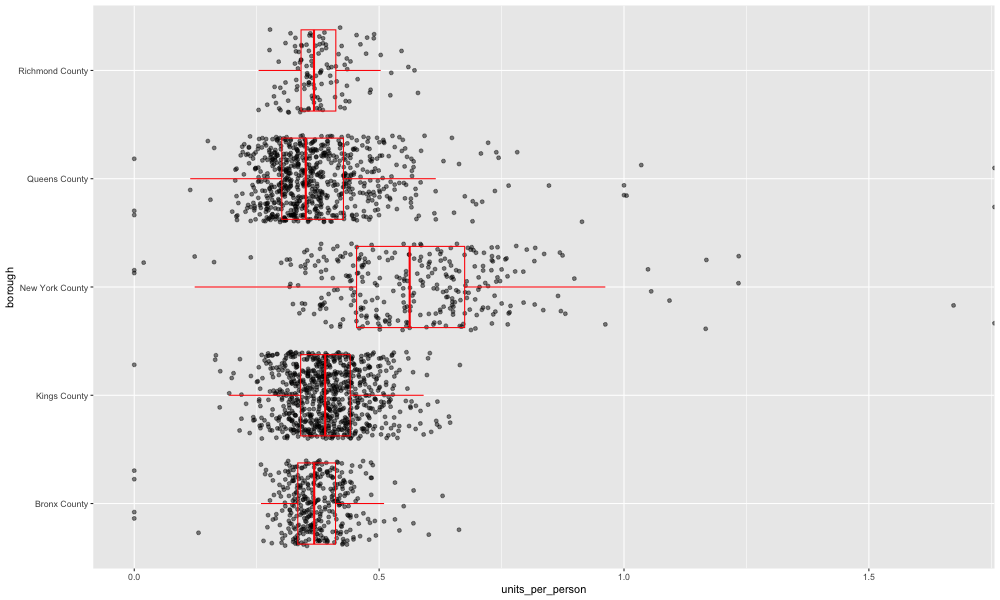

In [25]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=units_per_person, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

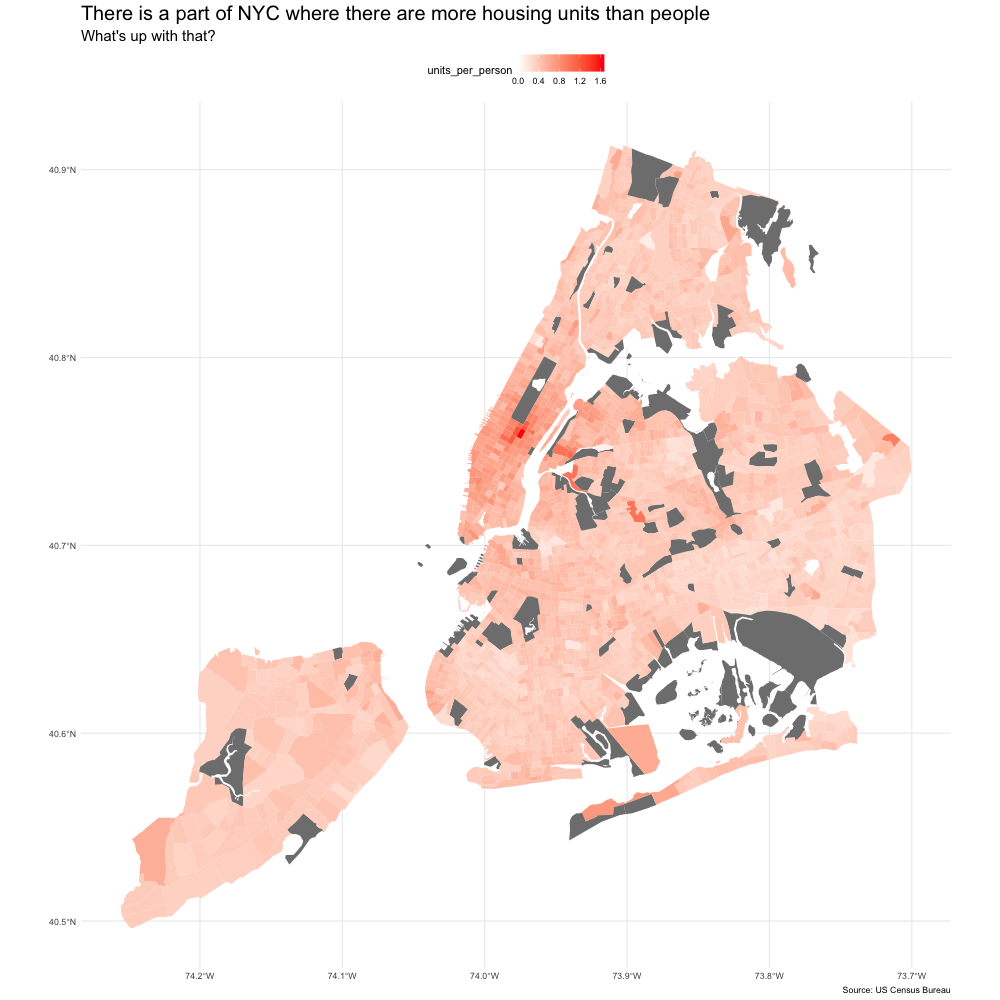

In [12]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = units_per_person)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "There is a part of NYC where there are more housing units than people",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )


## Bonus 🤔

Hmm...that map looks weird. What happened to the east river (the one that separates Queens from Manhattan). How can we fix it? Google around and see if you can find a tutorial to help you figure out the problem and fix it. Then, correct the mistake in the map above.

In [13]:
# What terms did you search for to find the answer? Link to the source of the answer (or the chatbot conversation) here:

# 👉 We alreadu made changes up